# Start

In [ ]:
# Code pour vider un dossier
import os
import shutil

def clear_directory(path):
    """
    Supprime récursivement tout le contenu d'un répertoire donné,
    puis recrée le répertoire vide.
    """
    if os.path.exists(path):
        print(f"Suppression du contenu du dossier : {path}")
        shutil.rmtree(path)
        print(f"Dossier {path} et son contenu supprimés.")
    else:
        print(f"Le dossier {path} n'existe pas, pas de suppression nécessaire.")

    os.makedirs(path, exist_ok=True)
    print(f"Dossier {path} recréé et vide.")

# --- Exemple d'utilisation (décommenter et remplacer 'YOUR_PATH_HERE') ---
# ATTENTION: Assurez-vous que le chemin est correct, cette opération est irréversible.
path_to_clear = "/content/drive/MyDrive/P8/Experiences"
clear_directory(path_to_clear)


Suppression du contenu du dossier : /content/drive/MyDrive/P8/Experiences
Dossier /content/drive/MyDrive/P8/Experiences et son contenu supprimés.
Dossier /content/drive/MyDrive/P8/Experiences recréé et vide.


## Imports

In [ ]:
import os
import numpy as np
import tensorflow as tf
import cv2
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import callbacks, losses, metrics, optimizers

!pip install mlflow -q
!pip install Pillow -q
import mlflow
import mlflow.tensorflow

print("TensorFlow version:", tf.__version__)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 789.2/789.2 kB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 22.7 MB/s eta 0:00:00
TensorFlow version: 2.19.0


In [ ]:
from tensorflow.keras import mixed_precision

# Activation de la politique "mixed_float16"
# Cela permet d'utiliser des float16 pour les calculs (rapide) et float32 pour les variables (stable)
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

print('Mixed precision policy:', policy.compute_dtype)

Mixed precision policy: float16


# CONFIG PATHS

In [ ]:
import os
from pathlib import Path
import mlflow

# --- CENTRALISATION DES CHEMINS (DRIVE) ---
PROJECT_ROOT = Path("/content/drive/MyDrive/P8")

# 1. Dossier Racine "Experiences"
EXP_ROOT = PROJECT_ROOT / "Experiences"

# 2. Sous-dossiers
MLFLOW_URI_DIR   = EXP_ROOT           # MLflow logs ici
CHECKPOINTS_DIR  = EXP_ROOT / "checkpoints"
MODELS_DIR       = EXP_ROOT / "Models"
ARTIFACTS_DIR    = EXP_ROOT / "artefacts"

# Création automatique de l'arborescence
for path in [EXP_ROOT, CHECKPOINTS_DIR, MODELS_DIR, ARTIFACTS_DIR]:
    if not path.exists():
        print(f"📁 Création dossier : {path}")
        path.mkdir(parents=True, exist_ok=True)

# Configuration MLflow immédiate
mlflow.set_tracking_uri("file://" + str(MLFLOW_URI_DIR))

print("\n✅ CONFIGURATION TERMINÉE")
print(f"📡 MLflow : {mlflow.get_tracking_uri()}")
print(f"💾 Checkpoints : {CHECKPOINTS_DIR}")
print(f"📦 Modèles Finaux : {MODELS_DIR}")

📁 Création dossier : /content/drive/MyDrive/P8/Experiences/checkpoints
📁 Création dossier : /content/drive/MyDrive/P8/Experiences/Models
📁 Création dossier : /content/drive/MyDrive/P8/Experiences/artefacts

✅ CONFIGURATION TERMINÉE
📡 MLflow : file:///content/drive/MyDrive/P8/Experiences
💾 Checkpoints : /content/drive/MyDrive/P8/Experiences/checkpoints
📦 Modèles Finaux : /content/drive/MyDrive/P8/Experiences/Models


## Mounting Drive

In [ ]:
import os
import shutil
from google.colab import drive

mount_point = '/content/drive'

# Check if the mount point exists and has contents
if os.path.exists(mount_point) and os.listdir(mount_point):
    print(f"Clearing existing contents in {mount_point} before mounting...")
    try:
        # Try to unmount first, in case it's a partially mounted or stale mount.
        # This command is often necessary before trying to clear or remount.
        _ = !fusermount -uz {mount_point}
        print(f"Successfully unmounted {mount_point}.")
    except Exception as e:
        print(f"Could not unmount {mount_point}: {e}. Proceeding with clearing directory.")

    # Remove all contents from the directory. If it was a broken mount, this cleans up.
    # If it's just a directory with files, this clears it for the mount.
    for item in os.listdir(mount_point):
        item_path = os.path.join(mount_point, item)
        try:
            if os.path.islink(item_path) or os.path.isfile(item_path):
                os.remove(item_path)
            elif os.path.isdir(item_path):
                shutil.rmtree(item_path)
        except Exception as e:
            print(f"Error removing {item_path}: {e}. This might prevent successful mounting.")
            # We don't want to halt execution here, as drive.mount will raise if it's still an issue.

drive.mount(mount_point, force_remount=True)

Clearing existing contents in /content/drive before mounting...
Successfully unmounted /content/drive.
Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Initializing Repository

In [ ]:
import os
import glob

# 1. Définition des Chemins
# DRIVE_SOURCE = "/content/drive/MyDrive/P8"   # Là où sont stockés vos zips (Source lente)
DRIVE_SOURCE = "/content/drive/MyDrive/P8/Data" # Essayez celui-ci si le premier ne trouve rien

LOCAL_DEST = "/content/P8/Data"              # Là où on veut travailler (Destination rapide)

print(f"🔄 Initialisation de la copie : Drive -> {LOCAL_DEST}")

if not os.path.exists(LOCAL_DEST):
    os.makedirs(LOCAL_DEST)

# 2. Recherche automatique des fichiers ZIP sur le Drive
# On cherche tout ce qui commence par 'P8_Cityscapes' et finit par '.zip'
found_zips = glob.glob(os.path.join(DRIVE_SOURCE, "**", "P8_Cityscapes*.zip"), recursive=True)

if not found_zips:
    print("❌ ERREUR CRITIQUE : Aucun fichier zip trouvé dans le Drive !")
    print(f"J'ai cherché dans : {DRIVE_SOURCE}")
    print("Vérifiez le chemin exact dans la colonne de gauche 'drive > MyDrive > ...'")
else:
    print(f"✅ Fichiers ZIP trouvés sur le Drive : {len(found_zips)}")
    for zip_file in found_zips:
        print(f"   -> Copie et Décompression de : {os.path.basename(zip_file)} ...")
        # Unzip silencieux (-q) mais avec écrasement (-o) vers le dossier local
        !unzip -q -o "{zip_file}" -d "{LOCAL_DEST}"

    print("\n🎉 SUCCESS : Toutes les données sont prêtes sur le Disque Rapide !")

    # 3. Configuration des variables GLOBALES
    IMG_DIR = os.path.join(LOCAL_DEST, "leftImg8bit")
    MASK_DIR = os.path.join(LOCAL_DEST, "gtFine")

    print(f"📁 IMG_DIR = {IMG_DIR}")
    if os.path.exists(IMG_DIR):
         print(f"   Contenu : {os.listdir(IMG_DIR)}")
    else:
         print("⚠️ Attention : Le dossier leftImg8bit n'est pas apparu. Vérifiez la structure du zip.")

🔄 Initialisation de la copie : Drive -> /content/P8/Data
✅ Fichiers ZIP trouvés sur le Drive : 2
   -> Copie et Décompression de : P8_Cityscapes_gtFine_trainvaltest.zip ...
   -> Copie et Décompression de : P8_Cityscapes_leftImg8bit_trainvaltest.zip ...

🎉 SUCCESS : Toutes les données sont prêtes sur le Disque Rapide !
📁 IMG_DIR = /content/P8/Data/leftImg8bit
   Contenu : ['test', 'val', 'train']


# Data Preparing

## Loading Data

In [ ]:
from pathlib import Path
import os

# --- 1. CONFIGURATION DES CHEMINS ---

# DRIVE (Stockage Permanent Résultats)
PROJECT_ROOT = Path("/content/drive/MyDrive/P8")

# LOCAL (Stockage Temporaire Rapide pour Données)
# C'est ici que le script 'unzip' a déposé les images
DATA_DIR_LOCAL = Path("/content/P8/Data")

IMG_DIR = DATA_DIR_LOCAL / "leftImg8bit"
MASK_DIR = DATA_DIR_LOCAL / "gtFine"

# Vérification
print(f"📂 INPUT (Lecture Rapide) : {IMG_DIR} -> Exists? {IMG_DIR.exists()}")
print(f"💾 OUTPUT (Sauvegarde Drive) : {PROJECT_ROOT} -> Exists? {PROJECT_ROOT.exists()}")

if not IMG_DIR.exists():
    print("⚠️ ATTENTION : Les données locales ne sont pas trouvées. Avez-vous lancé le script 'Unzip' ?")

📂 INPUT (Lecture Rapide) : /content/P8/Data/leftImg8bit -> Exists? True
💾 OUTPUT (Sauvegarde Drive) : /content/drive/MyDrive/P8 -> Exists? True


In [ ]:
print("Cities train images:", os.listdir(os.path.join(IMG_DIR, "train"))[:3])
print("Cities train masks:", os.listdir(os.path.join(MASK_DIR, "train"))[:3])

Cities train images: ['weimar', 'jena', 'monchengladbach']
Cities train masks: ['weimar', 'jena', 'monchengladbach']


## Fonction de listing image / masque

In [ ]:
from glob import glob
from PIL import Image

def get_file_pairs(split="train"):
    img_paths = []
    mask_paths = []

    for city in os.listdir(os.path.join(IMG_DIR, split)):
        city_img_dir = os.path.join(IMG_DIR, split, city)
        city_mask_dir = os.path.join(MASK_DIR, split, city)

        for img_file in glob(os.path.join(city_img_dir, "*_leftImg8bit.png")):
            mask_file = os.path.join(
                city_mask_dir,
                os.path.basename(img_file).replace(
                    "_leftImg8bit.png",
                    "_gtFine_labelIds.png"
                )
            )

            if os.path.exists(mask_file):
                try:
                    with Image.open(img_file) as img_pil:
                        img_pil.verify()
                    with Image.open(mask_file) as mask_pil:
                        mask_pil.verify()

                    img_paths.append(img_file)
                    mask_paths.append(mask_file)
                except Exception as e:
                    print(f"Skipping corrupted image/mask pair (INVALID PNG DATA): {img_file}, {mask_file} - Error: {e}")
            else:
                print(f"Skipping image due to missing mask file: {img_file}")

    return img_paths, mask_paths


## Test du chargement des chemins

In [ ]:
train_imgs, train_masks = get_file_pairs("train")
val_imgs, val_masks = get_file_pairs("val")

print(f"Train images: {len(train_imgs)}")
print(f"Val images: {len(val_imgs)}")

print(train_imgs[0])
print(train_masks[0])

Train images: 2975
Val images: 500
/content/P8/Data/leftImg8bit/train/weimar/weimar_000014_000019_leftImg8bit.png
/content/P8/Data/gtFine/train/weimar/weimar_000014_000019_gtFine_labelIds.png


## Chargement image + masque

In [ ]:
import cv2
import numpy as np

IMG_HEIGHT = 256
IMG_WIDTH = 512

CITYSCAPES_TO_8 = {
    7: 0, 8: 0,
    11: 1, 12: 1,
    13: 2, 14: 2, 15: 2, 16: 2, 17: 2, 18: 2,
    24: 3, 25: 3,
    21: 4,
    23: 5,
    19: 6, 20: 6, 22: 6,
    9: 7, 10: 7, 0: 7
}

def load_image_mask(img_path, mask_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT),
                      interpolation=cv2.INTER_NEAREST)

    new_mask = np.zeros_like(mask)
    for k, v in CITYSCAPES_TO_8.items():
        new_mask[mask == k] = v

    return img.astype(np.float32), new_mask.astype(np.uint8)


In [ ]:
import tensorflow as tf

# --- Paramètres du Pipeline ---
IMG_HEIGHT = 224  # Compatible MobileNetV2
IMG_WIDTH = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# --- Mapping des Classes ---
# 0:flat, 1:human, 2:vehicle, 3:construction, 4:object, 5:nature, 6:sky, 7:void
MAPPING_LIST = [
    7, 7, 7, 7, 7, 7, 7, # 0-6: void
    0, 0, 0, 0,          # 7-10: flat
    3, 3, 3, 3, 3, 3,    # 11-16: construction
    4, 4, 4, 4,          # 17-20: object
    5, 5,                # 21-22: nature
    6,                   # 23: sky
    1, 1,                # 24-25: human
    2, 2, 2, 2, 2, 2, 2, 2, # 26-33: vehicle
    7                    # 34: license plate
]
# Création d'un tenseur de lookup pour mapper rapidement les pixels
MAPPING_TENSOR = tf.constant(MAPPING_LIST + [7] * (256 - len(MAPPING_LIST)), dtype=tf.int32)

def parse_image_mask(img_path, mask_path):
    """ Chargement et prétraitement d'une image et de son masque """
    # 1. Image
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    # Normalisation [0,1]
    img = tf.cast(img, tf.float32) / 255.0

    # 2. Masque
    mask = tf.io.read_file(mask_path)
    mask = tf.io.decode_png(mask, channels=1)
    # Important : nearest neighbor pour ne pas interpoler les classes
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method='nearest')
    mask = tf.cast(mask, tf.int32)

    # 3. Mapping des classes
    mask = tf.gather(MAPPING_TENSOR, mask)

    return img, mask

def augment(img, mask):
    """ Data Augmentation appliquée simultanément à l'image et au masque """
    # Flip Horizontal
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)

    # Luminosité (Image seulement)
    img = tf.image.random_brightness(img, max_delta=0.1)

    # Contraste (Image seulement)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)

    return img, mask

def create_dataset(img_paths, mask_paths, training=False, augment_data=False):
    """ Création du Dataset TensorFlow optimisé """
    # Création du dataset de chemins
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))

    # Shuffle (uniquement pour le train)
    if training:
        dataset = dataset.shuffle(buffer_size=1000)

    # Chargement et Parsing (Parallélisé)
    dataset = dataset.map(parse_image_mask, num_parallel_calls=AUTOTUNE)

    # Augmentation (uniquement pour le train si demandé)
    if training and augment_data:
        dataset = dataset.map(augment, num_parallel_calls=AUTOTUNE)

    # Batching et Prefetching (Performance)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)

    return dataset

In [ ]:
# Création des datasets
# Train avec augmentation
train_ds_aug = create_dataset(train_imgs, train_masks, training=True, augment_data=True)
# Train sans augmentation (pour comparaison)
train_ds_no_aug = create_dataset(train_imgs, train_masks, training=True, augment_data=False)
# Validation (jamais d'augmentation)
val_ds = create_dataset(val_imgs, val_masks, training=False)

print(f"Datasets créés. Batch size: {BATCH_SIZE}")
# Vérification d'un batch
for img, mask in train_ds_aug.take(1):
    print(f"Image shape: {img.shape}, Type: {img.dtype}")
    print(f"Mask shape: {mask.shape}, Type: {mask.dtype}")

Datasets créés. Batch size: 32
Image shape: (32, 224, 224, 3), Type: <dtype: 'float32'>
Mask shape: (32, 224, 224, 1), Type: <dtype: 'int32'>


## Visualisation d’un exemple

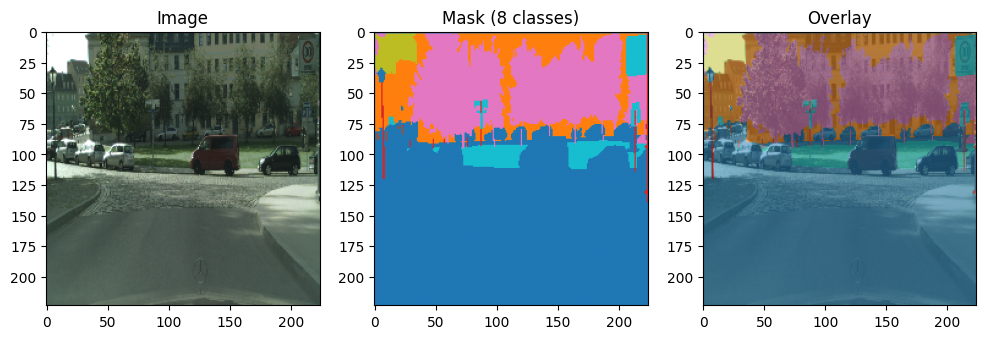

In [ ]:
import matplotlib.pyplot as plt

img, mask = load_image_mask(train_imgs[0], train_masks[0])

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Image")

plt.subplot(1,3,2)
plt.imshow(mask, cmap="tab10")
plt.title("Mask (8 classes)")

plt.subplot(1,3,3)
plt.imshow(img)
plt.imshow(mask, cmap="tab10", alpha=0.5)
plt.title("Overlay")

plt.show()

# Modeling

## Model Unet

In [ ]:
from tensorflow.keras import layers, models

def build_refined_unet(input_shape, num_classes=8):
    inputs = layers.Input(input_shape)

    # Fonction utilitaire pour un bloc conv (Conv -> BN -> ReLU)
    def conv_block(x, filters):
        x = layers.Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        return x

    # -------- Encoder (Downsampling) --------
    # Block 1
    c1 = conv_block(inputs, 16)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    # Block 2
    c2 = conv_block(p1, 32)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Block 3
    c3 = conv_block(p2, 64)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Block 4 (Bottleneck)
    c4 = conv_block(p3, 128)
    # Dropout pour régularisation
    c4 = layers.Dropout(0.2)(c4)

    # -------- Decoder (Upsampling) --------
    # Block 5
    u5 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c4)
    u5 = layers.Concatenate()([u5, c3])
    c5 = conv_block(u5, 64)

    # Block 6
    u6 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(c5)
    u6 = layers.Concatenate()([u6, c2])
    c6 = conv_block(u6, 32)

    # Block 7
    u7 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding="same")(c6)
    u7 = layers.Concatenate()([u7, c1])
    c7 = conv_block(u7, 16)

    # Output Layer
    # dtype='float32' est crucial si on utilise Mixed Precision pour la sortie finale
    outputs = layers.Conv2D(num_classes, 1, activation="softmax", dtype='float32')(c7)

    return models.Model(inputs, outputs, name="Light_UNet")

# Création du modèle avec les dimensions du pipeline
model_unet = build_refined_unet(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), # Utilise les variables globales
    num_classes=8
)

model_unet.summary()

Model: "Light_UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_4[0][0]  

 Total params: 484,968 (1.85 MB)

 Trainable params: 483,560 (1.84 MB)

 Non-trainable params: 1,408 (5.50 KB)

Loss function for optimizing models

In [ ]:
# --- Définition de la Dice Loss Custom ---
def dice_loss(y_true, y_pred):
    """
    Dice Loss pour segmentation multiclasse
    y_true: labels sparse (batch, h, w, 1) ou (batch, h, w)
    y_pred: probabilités (batch, h, w, num_classes)
    """
    y_true = tf.cast(y_true, tf.int32)
    # One-hot encoding du masque réel pour matcher la forme de y_pred
    y_true_one_hot = tf.one_hot(tf.squeeze(y_true), depth=8) # 8 classes

    numerator = 2 * tf.reduce_sum(y_true_one_hot * y_pred, axis=(0,1,2))
    denominator = tf.reduce_sum(y_true_one_hot + y_pred, axis=(0,1,2))

    # Dice par classe (ajout d'un epsilon pour éviter division par 0)
    dice_score = (numerator + 1e-7) / (denominator + 1e-7)

    # On renvoie 1 - dice_moyen
    return 1 - tf.reduce_mean(dice_score)

# --- Définition de la Loss Combinée (Combo Loss) ---
def combo_loss(y_true, y_pred):
    # Poids pour équilibrer (souvent 1:1 marche bien)
    ce = losses.sparse_categorical_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return ce + dice

# --- Mise à jour de la configuration ---
# On utilise maintenant notre combo_loss au lieu de juste Crossentropy
# loss_fn = losses.SparseCategoricalCrossentropy()  <-- Ancienne
loss_fn = combo_loss  # <-- Nouvelle
optimizer = optimizers.Adam(learning_rate=1e-3)

### Sans Data Augmentation

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import callbacks, losses, optimizers
import mlflow
from pathlib import Path

# # --- 1. CONFIGURATION DES CHEMINS (DRIVE) ---
# # On centralise tout ici pour éviter le bazar
# DRIVE_ROOT = Path("/content/drive/MyDrive/P8")
# EXP_ROOT = DRIVE_ROOT / "Experiences"

# # Sous-dossiers conformes à votre README
# CHECKPOINTS_DIR = EXP_ROOT / "checkpoints"
# MODELS_DIR = EXP_ROOT / "Models"
# MLFLOW_TRACKING_DIR = EXP_ROOT  # MLflow créera 'mlruns' ou '0' dedans

# # Création de l'arborescence si absente
# for path in [EXP_ROOT, CHECKPOINTS_DIR, MODELS_DIR]:
#     if not path.exists():
#         print(f"📁 Création dossier : {path}")
#         path.mkdir(parents=True, exist_ok=True)

# # Configuration MLflow pour écrire sur le Drive
# mlflow.set_tracking_uri("file://" + str(MLFLOW_TRACKING_DIR))
# print(f"📡 MLflow connecté : {mlflow.get_tracking_uri()}")


# --- 2. CONFIGURATION OPTIMIZER & LOSS ---
# On utilise la loss Dice+CE définie précédemment (ou SCCE par défaut)
try:
    loss_fn = combo_loss
    print("✅ Utilisation de la 'combo_loss' (Dice + Crossentropy)")
except NameError:
    print("⚠️ 'combo_loss' introuvable, utilisation de SparseCategoricalCrossentropy")
    loss_fn = losses.SparseCategoricalCrossentropy()

optimizer = optimizers.Adam(learning_rate=1e-3)


# --- 3. FONCTION TRAIN_MODEL (Version Finale) ---
def train_model(model, train_ds, val_ds, run_name, epochs=15):
    print(f"\n🚀 DÉMARRAGE RUN : {run_name}")

    # A. Préparation Checkpoint (Sur le Drive)
    run_ckpt_dir = CHECKPOINTS_DIR / run_name
    if not run_ckpt_dir.exists():
        run_ckpt_dir.mkdir(parents=True, exist_ok=True)

    ckpt_path = str(run_ckpt_dir / "best_model.keras")
    print(f"💾 Checkpoints : {ckpt_path}")

    # B. Callbacks
    ckpt_callback = callbacks.ModelCheckpoint(
        filepath=ckpt_path,
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    )
    es_callback = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    # C. Compilation
    # Ajout de run_eagerly=True pour éviter le problème avec LossScaleOptimizer et le mode graph.
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'], run_eagerly=True)

    # D. MLflow Run
    # On force l'expérience pour être sûr
    mlflow.set_experiment("Segmentation_P8")

    with mlflow.start_run(run_name=run_name) as run:
        # Log params
        mlflow.log_params({
            "model": model.name,
            "epochs": epochs,
            "optimizer": "adam",
            "loss": "combo_loss" if loss_fn == combo_loss else "scce"
        })

        # Autolog (courbes) sans les modèles lourds
        mlflow.tensorflow.autolog(log_models=False)

        # Entraînement
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            callbacks=[ckpt_callback, es_callback]
        )

        # --- E. Évaluation Détaillée (IoU / Dice) ---
        print("\n📊 Calcul des métriques détaillées par classe...")
        total_cm = np.zeros((8, 8))

        for images, masks in val_ds:
            preds = model.predict(images, verbose=0)
            preds_cls = np.argmax(preds, axis=-1)
            masks_np = masks.numpy().flatten()
            preds_np = preds_cls.flatten()

            # Confusion Matrix
            cm = tf.math.confusion_matrix(masks_np, preds_np, num_classes=8).numpy()
            total_cm += cm

        # Calculs
        iou_list = []
        dice_list = []
        classes = ['flat', 'human', 'vehicle', 'construction', 'object', 'nature', 'sky', 'void']

        print(f"\n{'CLASSE':<12} | {'IoU':<8} | {'Dice':<8}")
        print("-" * 35)

        for i in range(8):
            tp = total_cm[i, i]
            fp = np.sum(total_cm[:, i]) - tp
            fn = np.sum(total_cm[i, :]) - tp

            # IoU
            denom_iou = tp + fp + fn
            iou = tp / denom_iou if denom_iou > 0 else 0
            iou_list.append(iou)

            # Dice
            denom_dice = 2 * tp + fp + fn
            dice = 2 * tp / denom_dice if denom_dice > 0 else 0
            dice_list.append(dice)

            # Log & Print
            mlflow.log_metric(f"iou_class_{classes[i]}", iou)
            mlflow.log_metric(f"dice_class_{classes[i]}", dice)
            print(f"{classes[i]:<12} | {iou:.4f}   | {dice:.4f}")

        # Moyennes
        mean_iou = np.mean(iou_list)
        mean_dice = np.mean(dice_list)

        print("-" * 35)
        print(f"🏆 MEAN IoU: {mean_iou:.4f} | MEAN Dice: {mean_dice:.4f}")

        mlflow.log_metric("final_mean_iou", mean_iou)
        mlflow.log_metric("final_mean_dice", mean_dice)

        # Sauvegarde CSV
        df = pd.DataFrame({"Class": classes, "IoU": iou_list, "Dice": dice_list})
        csv_path = "classification_report.csv"
        df.to_csv(csv_path, index=False)
        mlflow.log_artifact(csv_path)

        # F. Sauvegarde Modèle Final (Format Keras 3 .keras)
        # Dans Experiences/Models/RunName/
        run_model_dir = MODELS_DIR / run_name
        if not run_model_dir.exists():
            run_model_dir.mkdir(parents=True, exist_ok=True)

        final_model_path = str(run_model_dir / "final_model.keras")
        model.save(final_model_path)
        print(f"📦 Modèle final sauvegardé : {final_model_path}")

        # Log dans MLflow aussi (optionnel mais pratique)
        # mlflow.tensorflow.log_model(model, "model")

        print(f"✅ Run terminé avec succès.")
        return history


# # --- 4. LANCEMENT DU PREMIER ENTRAÎNEMENT ---
# print("\n--- 🏁 Démarrage Expérience 1 : U-Net Baseline ---")

# # Instanciation (Assurez-vous que build_refined_unet est défini plus haut)
# model_unet_no_aug = build_refined_unet(
#     input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
#     num_classes=8
# )

# # Go !
# history_no_aug = train_model(
#     model=model_unet_no_aug,
#     train_ds=train_ds_no_aug,
#     val_ds=val_ds,
#     run_name="UNet_Light_NoAug",
#     epochs=15
# )

✅ Utilisation de la 'combo_loss' (Dice + Crossentropy)


### Avec Data Augmentation

In [ ]:
# --- Lancement de l'Expérience 2 : U-Net AVEC Augmentation ---

# 1. On ré-instancie un modèle vierge (très important pour ne pas continuer l'apprentissage précédent)
model_unet_aug = build_refined_unet(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    num_classes=8
)

# 2. Lancement de l'entraînement sur le dataset "train_ds_aug"
history_aug = train_model(
    model=model_unet_aug,
    train_ds=train_ds_aug,  # <--- Dataset AVEC augmentation
    val_ds=val_ds,
    run_name="UNet_Light_WithAug", # Nom différent pour MLflow
    epochs=15
)

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/mlflow/store/tracking/file_store.py", line 379, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/mlflow/store/tracking/file_store.py", line 477, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/mlflow/store/tracking/file_store.py", line 1662, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/mlflow/store/tracking/file_store.py", line 1655, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.1


🚀 DÉMARRAGE RUN : UNet_Light_WithAug
💾 Checkpoints : /content/drive/MyDrive/P8/Experiences/checkpoints/UNet_Light_WithAug/best_model.keras


Epoch 1/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4744 - loss: 2.4227   
Epoch 1: val_loss improved from inf to 3.47340, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/UNet_Light_WithAug/best_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.4758 - loss: 2.4184 - val_accuracy: 0.4336 - val_loss: 3.4734
Epoch 2/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.7857 - loss: 1.3772
Epoch 2: val_loss improved from 3.47340 to 2.92136, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/UNet_Light_WithAug/best_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 67s 714ms/step - accuracy: 0.7858 - loss: 1.3762 - val_accuracy: 0.5001 - val_loss: 2.9214
Epoch 3/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.8344 - loss: 1.0516
Epoch 3: val_loss improved from 2.92136 to 1.51615, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/UNet_Light_WithAug/best_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 67s 718ms/step - accuracy: 0.8344 - loss: 1.0513 - val_accuracy: 0.7291 - val_loss: 1.5162
Epoch 4/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.8477 - loss: 0.9421
Epoch 4: val_loss improved from 1.51615 to 1.18042, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/UNet_Light_WithAug/best_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 68s 721ms/step - accuracy: 0.8477 - loss: 0.9418 - val_accuracy: 0.7945 - val_loss: 1.1804
Epoch 5/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.8573 - loss: 0.8656
Epoch 5: val_loss did not improve from 1.18042
93/93 ━━━━━━━━━━━━━━━━━━━━ 66s 709ms/step - accuracy: 0.8573 - loss: 0.8655 - val_accuracy: 0.7532 - val_loss: 1.3366
Epoch 6/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.8636 - loss: 0.8182
Epoch 6: val_loss improved from 1.18042 to 0.99151, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/UNet_Light_WithAug/best_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 68s 721ms/step - accuracy: 0.8636 - loss: 0.8181 - val_accuracy: 0.8252 - val_loss: 0.9915
Epoch 7/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.8693 - loss: 0.7757
Epoch 7: val_loss improved from 0.99151 to 0.87401, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/UNet_Light_WithAug/best_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 67s 717ms/step - accuracy: 0.8693 - loss: 0.7757 - val_accuracy: 0.8539 - val_loss: 0.8740
Epoch 8/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.8750 - loss: 0.7413
Epoch 8: val_loss improved from 0.87401 to 0.83740, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/UNet_Light_WithAug/best_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 67s 716ms/step - accuracy: 0.8750 - loss: 0.7413 - val_accuracy: 0.8546 - val_loss: 0.8374
Epoch 9/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.8783 - loss: 0.7180
Epoch 9: val_loss improved from 0.83740 to 0.82537, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/UNet_Light_WithAug/best_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 67s 719ms/step - accuracy: 0.8783 - loss: 0.7180 - val_accuracy: 0.8592 - val_loss: 0.8254
Epoch 10/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.8827 - loss: 0.6887
Epoch 10: val_loss did not improve from 0.82537
93/93 ━━━━━━━━━━━━━━━━━━━━ 66s 706ms/step - accuracy: 0.8826 - loss: 0.6887 - val_accuracy: 0.8207 - val_loss: 0.9778
Epoch 11/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.8845 - loss: 0.6716
Epoch 11: val_loss improved from 0.82537 to 0.80973, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/UNet_Light_WithAug/best_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 67s 715ms/step - accuracy: 0.8845 - loss: 0.6716 - val_accuracy: 0.8576 - val_loss: 0.8097
Epoch 12/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.8851 - loss: 0.6620
Epoch 12: val_loss improved from 0.80973 to 0.80966, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/UNet_Light_WithAug/best_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 67s 716ms/step - accuracy: 0.8851 - loss: 0.6620 - val_accuracy: 0.8550 - val_loss: 0.8097
Epoch 13/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.8884 - loss: 0.6426
Epoch 13: val_loss improved from 0.80966 to 0.76630, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/UNet_Light_WithAug/best_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 68s 727ms/step - accuracy: 0.8884 - loss: 0.6426 - val_accuracy: 0.8601 - val_loss: 0.7663
Epoch 14/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.8919 - loss: 0.6267
Epoch 14: val_loss improved from 0.76630 to 0.73331, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/UNet_Light_WithAug/best_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 68s 724ms/step - accuracy: 0.8919 - loss: 0.6267 - val_accuracy: 0.8740 - val_loss: 0.7333
Epoch 15/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.8932 - loss: 0.6122
Epoch 15: val_loss did not improve from 0.73331
93/93 ━━━━━━━━━━━━━━━━━━━━ 67s 715ms/step - accuracy: 0.8932 - loss: 0.6122 - val_accuracy: 0.8694 - val_loss: 0.7525
Restoring model weights from the end of the best epoch: 14.

📊 Calcul des métriques détaillées par classe...

CLASSE       | IoU      | Dice    
-----------------------------------
flat         | 0.9082   | 0.9519
human        | 0.3623   | 0.5319
vehicle      | 0.6950   | 0.8200
construction | 0.7226   | 0.8389
object       | 0.1784   | 0.3028
nature       | 0.7866   | 0.8805
sky          | 0.8235   | 0.9032
void         | 0.6562   | 0.7924
-----------------------------------
🏆 MEAN IoU: 0.6416 | MEAN Dice: 0.7527
📦 Modèle final sauvegardé : /content/drive/MyDrive/P8/Experiences/Models/UNet_Light_WithAug/final_model.keras

### MLFLOW checking

In [ ]:
import mlflow
import pandas as pd

# Optionnel : Afficher toutes les colonnes
pd.set_option('display.max_columns', None)

# 1. Récupération des runs de l'expérience "Segmentation_P8"
try:
    exp = mlflow.get_experiment_by_name("Segmentation_P8")
    if exp is None:
        print("L'expérience 'Segmentation_P8' n'existe pas encore. Lancez d'abord l'entraînement.")
    else:
        # On filtre pour ne garder que ceux dont le nom contient "UNet"
        runs = mlflow.search_runs(
            experiment_ids=[exp.experiment_id],
            filter_string="tags.mlflow.runName LIKE '%UNet%'"
        )

        # 2. Colonnes à afficher
        cols_to_show = [
            "tags.mlflow.runName",
            "status",
            "start_time",
            "metrics.loss",
            "metrics.accuracy",
            "metrics.val_loss",
            "metrics.val_accuracy"
        ]
        existing_cols = [c for c in cols_to_show if c in runs.columns]

        # 3. Affichage
        if not runs.empty:
            print("--- Résultats : Modèle U-Net (Light) ---")
            # Tri par meilleure validation loss (la plus basse en premier)
            display(runs[existing_cols].sort_values("metrics.val_loss", ascending=True))

            # Petit bonus : Calcul du gain apporté par la Data Augmentation
            try:
                # On prend le min() car il peut y avoir plusieurs runs avec le même nom si on relance
                no_aug_loss = runs[runs['tags.mlflow.runName'] == 'UNet_Light_NoAug']['metrics.val_loss'].min()
                aug_loss = runs[runs['tags.mlflow.runName'] == 'UNet_Light_WithAug']['metrics.val_loss'].min()

                if pd.notna(no_aug_loss) and pd.notna(aug_loss):
                    print(f"\nComparaison Augmentation :")
                    print(f"Sans Aug: {no_aug_loss:.4f} vs Avec Aug: {aug_loss:.4f}")
                    if aug_loss < no_aug_loss:
                        print(f"✅ L'augmentation a amélioré le score de {no_aug_loss - aug_loss:.4f}")
                    else:
                        print(f"⚠️ L'augmentation n'a pas encore amélioré le score (peut nécessiter plus d'époques)")
            except Exception as e:
                print(f"Comparaison impossible : {e}")
        else:
            print("Aucun run U-Net trouvé pour l'instant.")

except Exception as e:
    print(f"Erreur lors de la récupération des runs : {e}")

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/mlflow/store/tracking/file_store.py", line 379, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/mlflow/store/tracking/file_store.py", line 477, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/mlflow/store/tracking/file_store.py", line 1662, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/mlflow/store/tracking/file_store.py", line 1655, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.1

--- Résultats : Modèle U-Net (Light) ---


,tags.mlflow.runName,status,start_time,metrics.loss,metrics.accuracy,metrics.val_loss,metrics.val_accuracy
0,UNet_Light_WithAug,FINISHED,2026-02-02 19:36:20.082000+00:00,0.619655,0.891100,0.752547,0.869377
2,UNet_Light_NoAug,FAILED,2026-02-02 19:27:52.778000+00:00,0.838681,0.866611,1.011045,0.831279
1,UNet_Light_WithAug,FAILED,2026-02-02 19:34:24.428000+00:00,NaN,NaN,NaN,NaN



Comparaison Augmentation :
Sans Aug: 1.0110 vs Avec Aug: 0.7525
✅ L'augmentation a amélioré le score de 0.2585


## Model MobileNetV2 - Unet

In [ ]:
from tensorflow.keras import layers, models, applications

def build_unet_mobilenetv2(input_shape, num_classes=8):
    """
    U-Net avec encodeur MobileNetV2 pré-entraîné (Transfer Learning)
    """
    inputs = layers.Input(shape=input_shape)

    # --- ENCODER (MobileNetV2) ---
    # On charge MobileNetV2 sans la tête de classification (include_top=False)
    # On utilise les poids 'imagenet' pour bénéficier du transfer learning
    base_model = applications.MobileNetV2(
        input_tensor=inputs,
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # On gèle les couches de l'encodeur pour commencer (faible learning rate plus tard ou fine-tuning)
    # Ou on les laisse entraînables si on a assez de données (Cityscapes 3000 images, c'est limite mais jouable)
    # Ici on laisse trainable=True pour adapter les features à la segmentation
    base_model.trainable = True

    # Récupération des sorties des blocs pour les Skip Connections
    # Noms des couches de MobileNetV2 correspondantes aux résolutions :
    # 112x112, 56x56, 28x28, 14x14
    layer_names = [
        'block_1_expand_relu',   # 64 filters -> 112x112
        'block_3_expand_relu',   # 128 filters -> 56x56
        'block_6_expand_relu',   # 256 filters -> 28x28
        'block_13_expand_relu',  # 512 filters -> 14x14
        'block_16_project',      # 1024 filters -> 7x7 (Bottleneck)
    ]

    # Création du modèle d'extraction de features
    # Cela permet de récupérer les sorties intermédiaires
    layers_output = [base_model.get_layer(name).output for name in layer_names]
    encoder = models.Model(inputs=base_model.input, outputs=layers_output)

    # Récupération des features
    # s1: 112x112, s2: 56x56, s3: 28x28, s4: 14x14, bottleneck: 7x7
    s1, s2, s3, s4, bottleneck = encoder(inputs)

    # --- DECODER (Upsampling + Concatenation) ---

    def upsample_block(x, skip, filters):
        # Upsampling
        x = layers.Conv2DTranspose(filters, 3, strides=2, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        # Concatenation (Skip Connection)
        # Gestion des petits décalages de taille si besoin (padding='same' devrait gérer)
        x = layers.Concatenate()([x, skip])

        # Convolutions après concaténation
        x = layers.Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        return x

    # Décodage progressif (7x7 -> 14x14 -> 28x28 -> 56x56 -> 112x112)
    d1 = upsample_block(bottleneck, s4, 512)
    d2 = upsample_block(d1, s3, 256)
    d3 = upsample_block(d2, s2, 128)
    d4 = upsample_block(d3, s1, 64)

    # Dernière montée d'échelle (112x112 -> 224x224)
    # MobileNetV2 commence par une conv avec stride 2, donc on a une division par 2 dès le début.
    # Il nous faut un dernier upsampling sans skip connection directe (ou avec l'input original si on veut)
    outputs = layers.Conv2DTranspose(32, 3, strides=2, padding='same')(d4)
    outputs = layers.BatchNormalization()(outputs)
    outputs = layers.Activation('relu')(outputs)

    # Couche de sortie finale (Segmentation Map)
    outputs = layers.Conv2D(num_classes, 1, activation='softmax', dtype='float32')(outputs)

    return models.Model(inputs, outputs, name="UNet_MobileNetV2")

# Instanciation du modèle
model_mobilenet = build_unet_mobilenetv2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), # 224x224x3
    num_classes=8
)

model_mobilenet.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "UNet_MobileNetV2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 112, 112, │  1,841,984 │ input_layer_4[0]… │
│ (Functional)        │ 96), (None, 56,   │            │                   │
│                     │ 56, 144), (None,  │            │                   │
│                     │ 28, 28, 192),     │            │                   │
│                     │ (None, 14, 14,    │            │                   │
│                     │ 576), (None, 7,   │            │                   │
│                     │ 7, 320)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_12 │ (None, 14, 14,    │  1,475,072 │ functional[0][4]  │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │      2,048 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_56       │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (Activation)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 14, 14,    │          0 │ activation_56[0]… │
│ (Concatenate)       │ 1088)             │            │ functional[0][3]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 14, 14,    │  5,014,016 │ concatenate_12[0… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │      2,048 │ conv2d_60[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_57       │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (Activation)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 14, 14,    │  2,359,808 │ activation_57[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │      2,048 │ conv2d_61[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_58       │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (Activation)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_13 │ (None, 28, 28,    │  1,179,904 │ activation_58[0]… │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │      1,024 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_59       │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                 

 Total params: 14,482,728 (55.25 MB)

 Trainable params: 14,445,992 (55.11 MB)

 Non-trainable params: 36,736 (143.50 KB)

### Sans Data Augmentation

In [ ]:
# --- Modèle 2 : U-Net MobileNetV2 ---

# Expérience 2.1 : SANS Augmentation (Baseline)
# ---------------------------------------------
# 1. Instanciation
model_mobilenet_no_aug = build_unet_mobilenetv2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    num_classes=8
)

# CORRECTION : On recrée l'optimiseur pour ce nouveau modèle
# Sinon l'instance globale 'optimizer' est liée au modèle précédent (U-Net) et plante.
optimizer = optimizers.Adam(learning_rate=1e-3)

# 2. Entraînement
history_mobilenet_no_aug = train_model(
    model=model_mobilenet_no_aug,
    train_ds=train_ds_no_aug,
    val_ds=val_ds,
    run_name="MobileNetV2_UNet_NoAug",
    epochs=15
)

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/mlflow/store/tracking/file_store.py", line 379, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/mlflow/store/tracking/file_store.py", line 477, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/mlflow/store/tracking/file_store.py", line 1662, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/mlflow/store/tracking/file_store.py", line 1655, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.1


🚀 DÉMARRAGE RUN : MobileNetV2_UNet_NoAug
💾 Checkpoints : /content/drive/MyDrive/P8/Experiences/checkpoints/MobileNetV2_UNet_NoAug/best_model.keras


Epoch 1/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7131 - loss: 1.5939
Epoch 1: val_loss improved from inf to 2.57023, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/MobileNetV2_UNet_NoAug/best_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 314s 3s/step - accuracy: 0.7143 - loss: 1.5889 - val_accuracy: 0.4514 - val_loss: 2.5702
Epoch 2/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8926 - loss: 0.7347
Epoch 2: val_loss did not improve from 2.57023
93/93 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.8926 - loss: 0.7344 - val_accuracy: 0.5317 - val_loss: 2.5916
Epoch 3/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9024 - loss: 0.6038
Epoch 3: val_loss improved from 2.57023 to 2.29270, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/MobileNetV2_UNet_NoAug/best_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.9024 - loss: 0.6036 - val_accuracy: 0.5826 - val_loss: 2.2927
Epoch 4/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9100 - loss: 0.5332
Epoch 4: val_loss did not improve from 2.29270
93/93 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.9100 - loss: 0.5332 - val_accuracy: 0.4899 - val_loss: 3.3928
Epoch 5/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9136 - loss: 0.5025
Epoch 5: val_loss did not improve from 2.29270
93/93 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.9135 - loss: 0.5024 - val_accuracy: 0.4818 - val_loss: 3.6607
Epoch 6/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9186 - loss: 0.4700
Epoch 6: val_loss did not improve from 2.29270
93/93 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.9186 - loss: 0.4700 - val_accuracy: 0.4841 - val_loss: 3.7168
Epoch 7/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9188 - loss: 0.4614
Epoch 7: val_loss did not improve from 2.29270
93/93 ━━━━━━━━━━

### Avec Data Augmentation

In [ ]:
# Expérience 2.2 : AVEC Augmentation
# ----------------------------------
# 1. Instanciation (Restart from scratch)
model_mobilenet_aug = build_unet_mobilenetv2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    num_classes=8
)

# 2. Entraînement
history_mobilenet_aug = train_model(
    model=model_mobilenet_aug,
    train_ds=train_ds_aug,
    val_ds=val_ds,
    run_name="MobileNetV2_UNet_WithAug",
    epochs=15
)

### MLFLOW checking

In [ ]:
import mlflow
import pandas as pd

# Optionnel : Afficher toutes les colonnes
pd.set_option('display.max_columns', None)

# 1. Récupération des runs de l'expérience "Segmentation_P8"
# On filtre pour garder U-Net OU MobileNet
runs = mlflow.search_runs(
    experiment_ids=[mlflow.get_experiment_by_name("Segmentation_P8").experiment_id],
    # On veut tout voir pour comparer, donc on enlève le filtre strict ou on met un OR
    filter_string="tags.mlflow.runName LIKE '%UNet%'"
)

# 2. Colonnes à afficher (ajout de params.optimizer si dispo)
cols_to_show = [
    "tags.mlflow.runName",
    "status",
    "metrics.loss",
    "metrics.accuracy",
    "metrics.val_loss",
    "metrics.val_accuracy",
    "params.epochs"
]
existing_cols = [c for c in cols_to_show if c in runs.columns]

# 3. Affichage Comparatif
if not runs.empty:
    print("--- 📊 Comparatif Global des Modèles ---")
    # Tri par meilleure validation loss
    sorted_runs = runs[existing_cols].sort_values("metrics.val_loss", ascending=True)
    display(sorted_runs)

    # Identifier le meilleur modèle absolu
    best_run = sorted_runs.iloc[0]
    best_name = best_run["tags.mlflow.runName"]
    best_score = best_run["metrics.val_loss"]
    print(f"\n🏆 Le meilleur modèle actuel est : {best_name} (Val Loss: {best_score:.4f})")

else:
    print("Aucun run trouvé.")

# Model DeepLabV3+ - MobileNetV2

In [ ]:
# --- Modèle 3 : DeepLabV3+ (Light Version avec MobileNetV2) ---

def build_deeplabv3_plus(input_shape, num_classes=8):
    inputs = layers.Input(shape=input_shape)

    # 1. Backbone MobileNetV2
    base_model = applications.MobileNetV2(
        input_tensor=inputs,
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # Extraction des features clés
    # High-level features (semantic) -> Sortie du dernier bloc (stride 16 ou 32)
    # Low-level features (details) -> Sortie début réseau (stride 4)
    x = base_model.get_layer('block_13_expand_relu').output  # Features riches (1/16)
    low_level_features = base_model.get_layer('block_3_expand_relu').output # Détails (1/4)

    # 2. Module ASPP (Atrous Spatial Pyramid Pooling)
    # Permet de voir le contexte à plusieurs échelles

    # Branche 1 : Conv 1x1
    b1 = layers.Conv2D(256, 1, padding='same', use_bias=False)(x)
    b1 = layers.BatchNormalization()(b1)
    b1 = layers.Activation('relu')(b1)

    # Branche 2 : Atrous Conv rate=6
    b2 = layers.Conv2D(256, 3, padding='same', dilation_rate=6, use_bias=False)(x)
    b2 = layers.BatchNormalization()(b2)
    b2 = layers.Activation('relu')(b2)

    # Branche 3 : Atrous Conv rate=12
    b3 = layers.Conv2D(256, 3, padding='same', dilation_rate=12, use_bias=False)(x)
    b3 = layers.BatchNormalization()(b3)
    b3 = layers.Activation('relu')(b3)

    # Branche 4 : Image Pooling (Contexte global)
    b4 = layers.GlobalAveragePooling2D()(x)
    b4 = layers.Reshape((1, 1, x.shape[-1]))(b4) # (Batch, 1, 1, Channels)
    b4 = layers.Conv2D(256, 1, padding='same', use_bias=False)(b4)
    b4 = layers.BatchNormalization()(b4)
    b4 = layers.Activation('relu')(b4)
    # Upsample b4 pour matcher la taille des autres branches
    b4 = layers.UpSampling2D(size=(x.shape[1], x.shape[2]), interpolation='bilinear')(b4)

    # Concaténation ASPP
    x = layers.Concatenate()([b1, b2, b3, b4])
    x = layers.Conv2D(256, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 3. Décodeur (Upsampling & Fusion)

    # On remonte x (1/16) vers la taille des low_level (1/4)
    x = layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(x)

    # Préparation des low_level_features (réduction de dimension 1x1)
    low_level = layers.Conv2D(48, 1, padding='same', use_bias=False)(low_level_features)
    low_level = layers.BatchNormalization()(low_level)
    low_level = layers.Activation('relu')(low_level)

    # Fusion
    x = layers.Concatenate()([x, low_level])

    # Dernières convolutions pour raffiner
    x = layers.Conv2D(256, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(256, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Upsampling final vers la taille originale (1/4 -> 1/1)
    x = layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(x)

    # Sortie Finale
    outputs = layers.Conv2D(num_classes, 1, activation='softmax', dtype='float32')(x)

    return models.Model(inputs, outputs, name="DeepLabV3_MobileNetV2")

# Test build
model_deeplab = build_deeplabv3_plus(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    num_classes=8
)
model_deeplab.summary()

### Sans Data Augmentation

In [ ]:
# --- Expérience 3.1 : DeepLabV3+ SANS Augmentation ---

# 1. Instanciation
model_deeplab_no_aug = build_deeplabv3_plus(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    num_classes=8
)

# 2. Entraînement
history_deeplab_no_aug = train_model(
    model=model_deeplab_no_aug,
    train_ds=train_ds_no_aug,
    val_ds=val_ds,
    run_name="DeepLabV3_MobileNet_NoAug",
    epochs=15
)

### Avec Data Augmentation

In [ ]:
# --- Expérience 3.2 : DeepLabV3+ AVEC Augmentation ---

# 1. Instanciation (pour repartir de zéro)
model_deeplab_aug = build_deeplabv3_plus(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    num_classes=8
)

# 2. Entraînement
history_deeplab_aug = train_model(
    model=model_deeplab_aug,
    train_ds=train_ds_aug,  # Dataset avec augmentation
    val_ds=val_ds,
    run_name="DeepLabV3_MobileNet_WithAug",
    epochs=15
)

### MLFLOW checking

In [ ]:
import mlflow
import pandas as pd

# Affichage complet
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

try:
    exp = mlflow.get_experiment_by_name("Segmentation_P8")
    if exp:
        # Récupérer TOUS les runs (pas de filtre)
        runs = mlflow.search_runs(experiment_ids=[exp.experiment_id])

        cols = [
            "tags.mlflow.runName", "status", "metrics.loss",
            "metrics.accuracy", "metrics.val_loss", "metrics.val_accuracy"
        ]
        # Filtrer colonnes existantes
        cols = [c for c in cols if c in runs.columns]

        if not runs.empty:
            print("--- 🏆 CLASSEMENT FINAL DES MODÈLES ---")
            # Tri par val_loss croissante (le plus petit est le meilleur)
            classement = runs[cols].sort_values("metrics.val_loss", ascending=True)
            display(classement)

            # Reco automatique
            best_model_name = classement.iloc[0]["tags.mlflow.runName"]
            print(f"\n👉 Le modèle recommandé pour le déploiement est : {best_model_name}")
        else:
            print("Aucun run trouvé.")
except Exception as e:
    print(f"Erreur MLflow: {e}")

### Visualisations examples

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, dataset, num_samples=3):
    """ Affiche Image Réelle / Masque Réel / Masque Predit """

    # Récupérer un batch
    for images, masks in dataset.take(1):
        # Prédiction
        preds = model.predict(images)
        # Argmax pour avoir la classe dominante par pixel
        preds = np.argmax(preds, axis=-1)

        plt.figure(figsize=(15, 5 * num_samples))

        for i in range(num_samples):
            # 1. Image Originale
            plt.subplot(num_samples, 3, i*3 + 1)
            plt.imshow(images[i])
            plt.title("Image Originale")
            plt.axis("off")

            # 2. Masque Réel (Ground Truth)
            plt.subplot(num_samples, 3, i*3 + 2)
            plt.imshow(masks[i], cmap='jet', vmin=0, vmax=7)
            plt.title("Masque Réel")
            plt.axis("off")

            # 3. Prédiction
            plt.subplot(num_samples, 3, i*3 + 3)
            plt.imshow(preds[i], cmap='jet', vmin=0, vmax=7)
            plt.title("Prédiction Modèle")
            plt.axis("off")

        plt.tight_layout()
        plt.show()
        break

# Lancer la visualisation sur le dataset de validation
# (Utilise le dernier modèle en mémoire, assurez-vous d'avoir entraîné un modèle avant)
try:
    print("Visualisation avec le dernier modèle entraîné...")
    visualize_predictions(model_deeplab_aug, val_ds) # Remplacez par le modèle que vous voulez tester
except NameError:
    print("Veuillez d'abord entraîner un modèle (ex: model_deeplab_aug) avant de visualiser.")

# Générations de schémas des modèles (pour documentation seulement)

schémas pour fiches techniques

In [ ]:
from tensorflow.keras.utils import plot_model

# Création du dossier pour stocker les images dans le Drive
rapport_images_dir = PROJECT_ROOT / "Documentation/Rapport_Images"
os.makedirs(rapport_images_dir, exist_ok=True)

# 1. Schéma U-Net Light
# On doit re-build le modèle s'il n'est pas en mémoire, ou utiliser celui existant
print("Génération du schéma U-Net...")
plot_model(
    model_unet_no_aug, # ou model_unet_aug
    to_file=f'{rapport_images_dir}/model_unet_structure.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB', # Top to Bottom
    expand_nested=True, # Pour voir l'intérieur
    dpi=96
)

# 2. Schéma MobileNetV2 U-Net
print("Génération du schéma MobileNet U-Net...")
plot_model(
    model_mobilenet_no_aug,
    to_file=f'{rapport_images_dir}/model_mobilenet_unet_structure.png',
    show_shapes=True,
    show_layer_names=False # False pour alléger car MobileNet est très long
)

# 3. Schéma DeepLabV3+
print("Génération du schéma DeepLabV3+...")
plot_model(
    model_deeplab_no_aug,
    to_file=f'{rapport_images_dir}/model_deeplab_structure.png',
    show_shapes=True,
    show_layer_names=False
)

print("✅ Images générées dans le dossier 'Rapport_Images'. Vous pouvez les télécharger pour votre rapport.")

images colorées

In [ ]:
# !pip install visualkeras --quiet
import visualkeras

rapport_images_dir = PROJECT_ROOT / "Documentation/Rapport_Images"
os.makedirs(rapport_images_dir, exist_ok=True)

def save_flat_visual(model, filename):
    print(f"Génération visuelle 2D (Flat) pour {model.name}...")
    try:
        # draw_volume=False pour désactiver la 3D
        img = visualkeras.layered_view(
            model,
            legend=True,
            draw_volume=False,  # <--- C'est ici que ça se joue
            spacing=15,          # Espacement entre couches
            scale_xy=2           # Grossir un peu les carrés
        )
        save_path = f"{rapport_images_dir}/{filename}"
        img.save(save_path)
        print(f"✅ Sauvegardé : {save_path}")
        display(img)
    except Exception as e:
        print(f"Erreur : {e}")

# Génération pour vos modèles
save_flat_visual(model_unet_no_aug, "flat_unet.png")
# save_flat_visual(model_mobilenet_no_aug, "flat_mobilenet.png") # Peut être très large
# save_flat_visual(model_deeplab_no_aug, "flat_deeplab.png")